# With the AML network, observe the effects of BCL2 inhibition on patient scores

### Importing BMatrix, BooleanNetwork, and Clinical Data

In [1]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt

# import booleanNetwork module from ./src
import sys
sys.path.append('./src/')
import booleanNetwork as bn
import BMatrix  

drug_response_df = pd.read_excel("./input_files/drug_response_df.xlsx",keep_default_na=False)

In [2]:
drug_response_df # 223 samples

,labId,mutation_profiles,original_profiles,inhibitor,ic50,auc
0,14-00739,,"TLN2,GTF3C3",Venetoclax,0.013717,60.835856
1,14-00781,TET2,"CHD5,SMC3,SMC3,KRAS,KRAS,ADNP2,SCAF1,LGI2,LGI2...",Venetoclax,10.000000,186.162648
2,14-00787,CEBPA,"KIF26A,NKIRAS2,NKIRAS2,ZNF98,CEBPA,TMEM214,TME...",Venetoclax,0.174267,131.204862
3,14-00798,NRAS,"NRAS,KRAS,UBE3B,IHH,ANO7,FOXP1",Venetoclax,10.000000,286.250141
4,14-00800,"TET2,CBL","CBL,CBL,SF3B1,SF3B1,TET2,TET2",Venetoclax,10.000000,243.226039
...,...,...,...,...,...,...
218,17-00072,"SRSF2,STAG2,ASXL1,CUX1,NRAS","NRAS,NRAS,STT3A,SRSF2,KYNU,ASXL1,CUX1,STAG2",Venetoclax,0.013717,47.734109
219,17-00077,"KIT,RAD21","KIT,RAD21",Venetoclax,0.013717,80.930885
220,17-00093,FLT3,"IQSEC3,FLT3",Venetoclax,0.013717,91.918451
221,17-00094,"RUNX1,JAK2,SRSF2,DNMT3A","SRSF2,DMPK,DNMT3A,DNMT3A,RUNX1,RUNX1,RUNX1,RUN...",Venetoclax,10.000000,276.290452


### Getting the variables needed for the simulation and calculation

In [3]:
file = './input_files/fig3_AML_equations.txt'

equations = BMatrix.get_equations(file)
gene_dict = BMatrix.get_gene_dict(equations)
upstream_genes = BMatrix.get_upstream_genes(equations)

connectivity_matrix = BMatrix.get_connectivity_matrix(equations,upstream_genes,gene_dict)
#print(connectivity_matrix)
#print('\n')

truth_table = BMatrix.get_truth_table(equations,upstream_genes)
#print(truth_table)

ngenes= len(equations)
print('Number of genes:',ngenes)

Number of genes: 78


In [4]:
file_equations = './input_files/fig3_calculating_equations.txt'

cal_equations = BMatrix.get_equations(file_equations)
cal_upstream_genes = BMatrix.get_cal_upstream_genes(cal_equations)
cal_functions = BMatrix.get_cal_functions(cal_equations)

In [5]:
mutation_dict = None

file_perturbed = './input_files/perturbed_genes.txt'
perturbed_dict = BMatrix.get_mutation_dict(file_perturbed)
perturbed_genes = 'BCL2'

### Simulation of BCL2 inhibition

In [6]:
all_profiles = np.array([[profile] for profile in drug_response_df['mutation_profiles']])

In [7]:
before_inhibition = []
networks = {}

for i in range(len(all_profiles)): 
    profile = all_profiles[i,0] # Gets the profile as a string ex. 'FLT3'
    print(profile)
    
    mutated_connectivity_matrix, x0 = BMatrix.get_knocking_genes(profile, mutation_dict, connectivity_matrix, gene_dict)

    #making the networks and running the simulation
    print('starting simulation')
    network = bn.BooleanNetwork(ngenes, mutated_connectivity_matrix, truth_table, x0)
    network_traj = network.update_noise(0.05, 200000)
    # Do way need to store the network_traj?
    
    #calculating the scores  
    print('getting final score')
    cal_range = network_traj[-100000:]
    
    scores_dict, final_score = BMatrix.get_calculating_scores(network_traj, cal_functions, cal_upstream_genes, gene_dict, cal_range)

    print(final_score)
    
    before_inhibition.append(final_score)
    
print(before_inhibition)


starting simulation
getting final score
1.28228
TET2
starting simulation
getting final score
1.29184
CEBPA
starting simulation
getting final score
1.35904
NRAS
starting simulation
getting final score
1.36126
TET2,CBL
starting simulation
getting final score
1.28868
RUNX1,GATA2,CBL
starting simulation
getting final score
1.3063

starting simulation
getting final score
1.3531
FLT3,ASXL1
starting simulation
getting final score
1.32863
WT1,NRAS
starting simulation
getting final score
1.29741
NRAS
starting simulation
getting final score
1.34143
NPM1,IDH2
starting simulation
getting final score
1.26456
ASXL1,RUNX1,SRSF2,IDH2
starting simulation
getting final score
1.27236
RUNX1,SRSF2,IDH1
starting simulation
getting final score
1.30538
SRSF2,TP53
starting simulation
getting final score
1.25821
NPM1,FLT3,WT1,ASXL1
starting simulation
getting final score
1.23355
NRAS,NPM1,DOT1L
starting simulation
getting final score
1.33566
NRAS,NPM1,IDH1,DNMT3A,SOS1
starting simulation
getting final score
1.

Text(0.5, 1.0, 'Distribution of scores before inhibition')

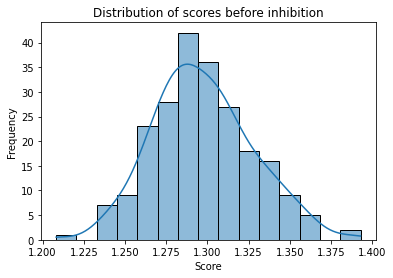

In [9]:
# plot the distribution of scores
sns.histplot(before_inhibition, kde=True)
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Distribution of scores before inhibition')

In [10]:
after_inhibition = []
networks = {}

for i in range(len(all_profiles)): 
    profile = all_profiles[i,0] # Gets the profile as a string ex. 'FLT3'
    print(profile)
    
    mutated_connectivity_matrix, x0 = BMatrix.get_knocking_genes(profile, mutation_dict, connectivity_matrix, gene_dict, perturbed_genes, perturbed_dict)

    #making the networks and running the simulation
    print('starting simulation')
    network = bn.BooleanNetwork(ngenes, mutated_connectivity_matrix, truth_table, x0)
    network_traj = network.update_noise(0.05, 200000)
    
    #calculating the scores  
    print('getting final score')
    cal_range = network_traj[-100000:]
    
    scores_dict, final_score = BMatrix.get_calculating_scores(network_traj, cal_functions, cal_upstream_genes, gene_dict, cal_range)

    print(final_score)
    
    after_inhibition.append(final_score)
    
print(after_inhibition)


starting simulation
getting final score
0.85343
TET2
starting simulation
getting final score
0.76638
CEBPA
starting simulation
getting final score
0.73153
NRAS
starting simulation
getting final score
0.81941
TET2,CBL
starting simulation
getting final score
0.78585
RUNX1,GATA2,CBL
starting simulation
getting final score
0.71893

starting simulation
getting final score
0.79899
FLT3,ASXL1
starting simulation
getting final score
0.75635
WT1,NRAS
starting simulation
getting final score
0.77147
NRAS
starting simulation
getting final score
0.75076
NPM1,IDH2
starting simulation
getting final score
0.79452
ASXL1,RUNX1,SRSF2,IDH2
starting simulation
getting final score
0.77249
RUNX1,SRSF2,IDH1
starting simulation
getting final score
0.79821
SRSF2,TP53
starting simulation
getting final score
0.74763
NPM1,FLT3,WT1,ASXL1
starting simulation
getting final score
0.7389
NRAS,NPM1,DOT1L
starting simulation
getting final score
0.75674
NRAS,NPM1,IDH1,DNMT3A,SOS1
starting simulation
getting final score
0

Text(0.5, 1.0, 'Distribution of scores after inhibition')

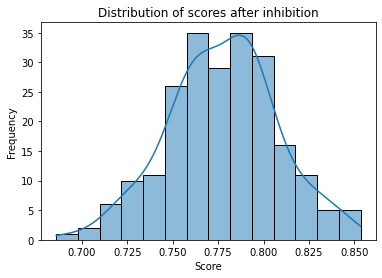

In [12]:
# plot the distribution of scores
sns.histplot(after_inhibition, kde=True)
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Distribution of scores after inhibition')

In [13]:
labId = drug_response_df['labId'][0:len(all_profiles)]

scores_df = pd.DataFrame({
    'labId': labId,
    'no_inhibition_score': before_inhibition,
    'BCL2_inhibition_score': after_inhibition
})

scores_df['score_diff'] = scores_df.apply(lambda x: x['no_inhibition_score'] - x['BCL2_inhibition_score'], axis=1) 

In [18]:
scores_df['score_diff_ratio'] = scores_df.apply(lambda x:  x['BCL2_inhibition_score']/x['no_inhibition_score'] , axis=1) 

In [19]:
BCL2_inhibition_df = pd.merge(drug_response_df, scores_df, on='labId', how='outer')

BCL2_inhibition_df

,labId,mutation_profiles,original_profiles,inhibitor,ic50,auc,no_inhibition_score,BCL2_inhibition_score,score_diff,score_diff_ratio
0,14-00739,,"TLN2,GTF3C3",Venetoclax,0.013717,60.835856,1.28228,0.85343,0.42885,0.665557
1,14-00781,TET2,"CHD5,SMC3,SMC3,KRAS,KRAS,ADNP2,SCAF1,LGI2,LGI2...",Venetoclax,10.000000,186.162648,1.29184,0.76638,0.52546,0.593247
2,14-00787,CEBPA,"KIF26A,NKIRAS2,NKIRAS2,ZNF98,CEBPA,TMEM214,TME...",Venetoclax,0.174267,131.204862,1.35904,0.73153,0.62751,0.538270
3,14-00798,NRAS,"NRAS,KRAS,UBE3B,IHH,ANO7,FOXP1",Venetoclax,10.000000,286.250141,1.36126,0.81941,0.54185,0.601950
4,14-00800,"TET2,CBL","CBL,CBL,SF3B1,SF3B1,TET2,TET2",Venetoclax,10.000000,243.226039,1.28868,0.78585,0.50283,0.609810
...,...,...,...,...,...,...,...,...,...,...
218,17-00072,"SRSF2,STAG2,ASXL1,CUX1,NRAS","NRAS,NRAS,STT3A,SRSF2,KYNU,ASXL1,CUX1,STAG2",Venetoclax,0.013717,47.734109,1.30843,0.77966,0.52877,0.595874
219,17-00077,"KIT,RAD21","KIT,RAD21",Venetoclax,0.013717,80.930885,1.28504,0.80773,0.47731,0.628564
220,17-00093,FLT3,"IQSEC3,FLT3",Venetoclax,0.013717,91.918451,1.27384,0.77087,0.50297,0.605154
221,17-00094,"RUNX1,JAK2,SRSF2,DNMT3A","SRSF2,DMPK,DNMT3A,DNMT3A,RUNX1,RUNX1,RUNX1,RUN...",Venetoclax,10.000000,276.290452,1.30484,0.72463,0.58021,0.555340


0.028720084516876073

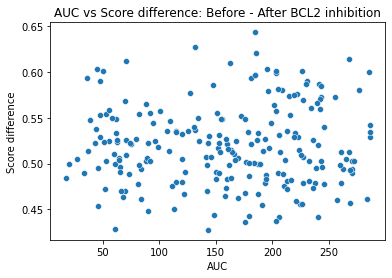

In [26]:
# scatter plot of auc and score_diff 
sns.scatterplot(data=BCL2_inhibition_df, x='auc', y='score_diff')
plt.xlabel('AUC')
plt.ylabel('Score difference')
plt.title('AUC vs Score difference: Before - After BCL2 inhibition')

# correlation between auc and score_diff
BCL2_inhibition_df['auc'].corr(BCL2_inhibition_df['score_diff'])

In [ ]:

# scatter plot of auc and no_inhibition_score
sns.scatterplot(data=BCL2_inhibition_df, x='auc', y='no_inhibition_score')
plt.xlabel('AUC')
plt.ylabel('Score')
plt.title('AUC vs Score before inhibition')

# scatter plot of auc and BCL2_inhibition_score
sns.scatterplot(data=BCL2_inhibition_df, x='auc', y='BCL2_inhibition_score')
plt.xlabel('AUC')
plt.ylabel('Score')
plt.title('AUC vs Score after BCL2 inhibition')

Text(0.5, 1.0, 'AUC vs Score ratio')

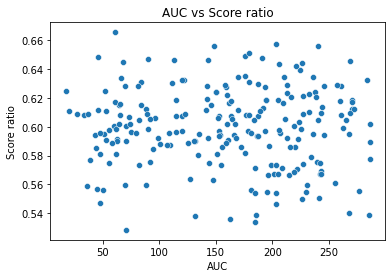

In [21]:

# scatter plot of auc and score_diff_ratio
sns.scatterplot(data=BCL2_inhibition_df, x='auc', y='score_diff_ratio')
plt.xlabel('AUC')
plt.ylabel('Score ratio')
plt.title('AUC vs Score ratio')


In [23]:
# correlation between auc and score_diff_ratio
BCL2_inhibition_df['auc'].corr(BCL2_inhibition_df['score_diff_ratio'])


-0.02392678945809198

In [24]:
BCL2_inhibition_df.to_excel('BCL2_inhibition_df_fullAMLGraph.xlsx', index=False, na_rep='')